<a href="https://colab.research.google.com/github/s1m0nS/projectRegularization/blob/main/UNet_binary_segmentation_PyTorch_v2-complete-comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Binary semantic segmentation example using U-Net
Preparation of dataset and model training code from here:

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [ ]:
import os
import torch
import torchvision
from tqdm import tqdm

print(torch.__version__)
print(torchvision.__version__)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

1.13.1+cu116
0.14.1+cu116
cuda


See GPU information:

In order to use a GPU with your notebook, select the Runtime > Change runtime type menu, and then set the hardware accelerator dropdown to GPU.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar 10 11:59:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    49W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape dropdown. After, re-execute the code cell.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


### Mount Google Drive

For this implementation files have to be stored on your Google Drive. If you are working locally, have the dataset on your pc. I did not use the whole MapAI dataset for training, because I only have 15 GB on my Google Drive.

In [ ]:
# Mount Google Drive if you use it.

from google.colab import drive
drive.mount('/content/drive/')

# Unzip dataset --> run only in Colab
import zipfile

mapai_zip = '/content/drive/MyDrive/datasets/mapai_small.zip'
zip_ref = zipfile.ZipFile(mapai_zip, 'r')
zip_ref.extractall("/tmp") # extracting dataset to tmp folder
zip_ref.close()

Mounted at /content/drive/


#### CONFIGURE YOUR PATHS AND HYPERPARAMETERS FOR TRAINING BELOW.

In [2]:
# CONFIGURE PATHS

GD_PATH = "/content/drive/MyDrive/models/"

# TRAIN
TRAIN_IMG_DIR = "/tmp/mapai_small/train/images/"
TRAIN_MASK_DIR = "/tmp/mapai_small/train/masks/"

# VAL
VAL_IMG_DIR = "/tmp/mapai_small/val/images/"
VAL_MASK_DIR = "/tmp/mapai_small/val/masks/"

# TEST
TEST_IMG_DIR = "/tmp/mapai_small/test/images/"
TEST_MASK_DIR = "/tmp/mapai_small/test/masks/"


# CONFIGURE MapAI DATASET
NUM_CHANNELS = 3
NUM_LEVELS  = 3
NUM_CLASSES = 1

init_lr = 1e-3 # learning rate
EPOCHS = 100 # epochs to train
BATCH_SIZE = 8

# IMAGE SHAPE
IMG_WIDTH = 500
IMG_HEIGHT = 500

THRESHOLD  = 0.5
base_output = "out"

# OUTPUT PATHS
MODEL_PATH = os.path.join(GD_PATH, "unet-100-epochs.pth") # change depending on the number of epochs
print(MODEL_PATH)
PLOT_PATH  = os.path.join(GD_PATH, "training_plot.png") # plot for training/val loss
print(PLOT_PATH)
TEST_PATHS = os.path.join(GD_PATH, "test_paths.txt") # file to store the paths for test images
print(TEST_PATHS)

NameError: ignored

### Load and read the MapAI dataset

In [ ]:
from torch.utils.data import Dataset
import cv2

class mapAIdataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
		
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
	
		# return a tuple of the image and its mask
		return (image, mask)

### Build UNET architecture
I used the basic UNET architecture, I did not want to mess much with changing the neural network, rather focus more on applying regularization, because that is more important for my use case for cadastral mapping.

When comparing different models, we can just add a different model architecture below.

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # DOWN part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # UP part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

### Training the segmentation model
Below we append the paths for TRAIN/VAL/TEST sets - images/masks.

In [ ]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from imutils import paths
import time

# TRAINING
TrainImagePaths = sorted(list(paths.list_images(TRAIN_IMG_DIR)))
TrainMaskPaths = sorted(list(paths.list_images(TRAIN_MASK_DIR)))

print('TRAINING: ')
print(TrainImagePaths[0], TrainMaskPaths[0])

# VALIDATION
ValImagePaths = sorted(list(paths.list_images(VAL_IMG_DIR)))
ValMaskPaths = sorted(list(paths.list_images(VAL_MASK_DIR)))

print('VALIDATION:')
print(ValImagePaths[0], ValMaskPaths[0])

# TEST
TestImagePaths = sorted(list(paths.list_images(TEST_IMG_DIR)))
TestMaskPaths = sorted(list(paths.list_images(TEST_MASK_DIR))) # this does not exists

print('TEST:')
print(TestImagePaths[0], TestMaskPaths[0])

# Unpack the data
(train_images, train_masks) = (TrainImagePaths, TrainMaskPaths)

(val_images, val_masks) = (ValImagePaths, ValMaskPaths)

(test_images, test_masks) = (TestImagePaths, TestMaskPaths)

# Write the testing images to disk so that we can use them later
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(test_images))
f.close()

TRAINING: 
/tmp/mapai_small/train/images/6051_689_0.png /tmp/mapai_small/train/masks/6051_689_0.png
VALIDATION:
/tmp/mapai_small/val/images/6259_564_19.png /tmp/mapai_small/val/masks/6259_564_19.png
TEST:
/tmp/mapai_small/test/images/6078_637_91.png /tmp/mapai_small/test/masks/6078_637_91.png
[INFO] saving testing image paths...


Just check if everything is correct.

In [ ]:
train_images[0:2], train_masks[0:2]

(['/tmp/mapai_small/train/images/6051_689_0.png',
  '/tmp/mapai_small/train/images/6051_689_38.png',
  '/tmp/mapai_small/train/images/6051_689_4.png',
  '/tmp/mapai_small/train/images/6051_689_42.png',
  '/tmp/mapai_small/train/images/6051_689_44.png'],
 ['/tmp/mapai_small/train/masks/6051_689_0.png',
  '/tmp/mapai_small/train/masks/6051_689_38.png',
  '/tmp/mapai_small/train/masks/6051_689_4.png',
  '/tmp/mapai_small/train/masks/6051_689_42.png',
  '/tmp/mapai_small/train/masks/6051_689_44.png'])

In [ ]:
val_images[0:2], val_masks[0:2]

(['/tmp/mapai_small/val/images/6259_564_19.png',
  '/tmp/mapai_small/val/images/6259_564_2.png',
  '/tmp/mapai_small/val/images/6259_564_24.png',
  '/tmp/mapai_small/val/images/6259_564_31.png',
  '/tmp/mapai_small/val/images/6259_564_34.png'],
 ['/tmp/mapai_small/val/masks/6259_564_19.png',
  '/tmp/mapai_small/val/masks/6259_564_2.png',
  '/tmp/mapai_small/val/masks/6259_564_24.png',
  '/tmp/mapai_small/val/masks/6259_564_31.png',
  '/tmp/mapai_small/val/masks/6259_564_34.png'])

In [ ]:
test_images[0:2], test_masks[0:2]

(['/tmp/mapai_small/test/images/6078_637_91.png',
  '/tmp/mapai_small/test/images/6078_638_24.png',
  '/tmp/mapai_small/test/images/6078_638_99.png',
  '/tmp/mapai_small/test/images/6084_553_93.png',
  '/tmp/mapai_small/test/images/6104_603_16.png'],
 ['/tmp/mapai_small/test/masks/6078_637_91.png',
  '/tmp/mapai_small/test/masks/6078_638_24.png',
  '/tmp/mapai_small/test/masks/6078_638_99.png',
  '/tmp/mapai_small/test/masks/6084_553_93.png',
  '/tmp/mapai_small/test/masks/6104_603_16.png'])

### Define transformations

I tried out different data augmentation techniques, including Horizontal Flip, Vertical Flip, Contrast, Brightness. They did not improve my results much, the validation and training loss were actually worse than without data augmentation techniques.

https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py


In [ ]:
# define transformations
import torchvision.transforms as T

transforms = T.Compose([T.ToPILImage(),
                        T.Resize((IMG_HEIGHT,IMG_WIDTH)),
                        T.ToTensor()])

# create the train and test datasets
trainDS = mapAIdataset(imagePaths=train_images,
                       maskPaths=train_masks,
                       transforms=transforms)

valDS = mapAIdataset(imagePaths=val_images,
                     maskPaths=val_masks,
                     transforms=transforms)

testDS = mapAIdataset(imagePaths=test_images,
                      maskPaths=test_masks,
                      transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(valDS)} examples in the validation set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS,
                         shuffle=True,
                         batch_size=BATCH_SIZE,
                         pin_memory=PIN_MEMORY,
                         num_workers=os.cpu_count()
                         )

valLoader = DataLoader(valDS,
                       shuffle=False,
                       batch_size=BATCH_SIZE,
                       pin_memory=PIN_MEMORY,
                       num_workers=os.cpu_count()
                       )

testLoader = DataLoader(testDS,
                        shuffle=False,
                        batch_size=BATCH_SIZE,
                        pin_memory=PIN_MEMORY,
                        num_workers=os.cpu_count()
                        )

[INFO] found 800 examples in the training set...
[INFO] found 200 examples in the validation set...
[INFO] found 25 examples in the test set...


### Initialize UNET model for training

Here we initialize the defined UNET model for training and calculate the steps per epoch for train/val/test set.

In [ ]:
model = UNET().to(DEVICE)

# loss / optimizer
lossFunction = BCEWithLogitsLoss()
opt = Adam(model.parameters(), lr=init_lr)

# calculate steps per epoch for train/val/test
trainSteps = len(trainDS) // BATCH_SIZE 
valSteps = len(valDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

print(trainSteps, valSteps, testSteps)

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}
H

100 25 3


{'train_loss': [], 'val_loss': []}

In [ ]:
torch.cuda.empty_cache() # PyTorch thing to empty cache

### TRAINING THE MODEL

Run this piece of code only if you want to train the model from scratch.

TO DO:

*   Calculate Intersection over Union
*   Calculate Accuracy metrics

I do not know exactly how to add these metrics into the training process when perfoming validation. Needs some more work.



In [ ]:
# loop over epochs
print("[INFO] training UNET ...")
startTime = time.time()

for epoch in tqdm(range(EPOCHS)):
    tast
    model.train()

    # initialize total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0

    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send output to device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))

        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunction(pred, y)

        # kill previously accumulated gradients then
        # perform backpropagation and update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        # add the loss to the total training loss
        totalTrainLoss += loss

    # switch of autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()

        # loop over the validation set
        for (x, y) in valLoader:
             # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunction(pred, y)

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
        
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, EPOCHS))
    print("Train loss: {:.6f}, Val loss: {:.4f}".format(avgTrainLoss, avgValLoss))
        
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
    

[INFO] training UNET ...


  1%|          | 1/100 [00:30<50:48, 30.79s/it]

[INFO] EPOCH: 1/100
Train loss: 0.322177, Val loss: 0.3131


  2%|▏         | 2/100 [00:53<42:44, 26.17s/it]

[INFO] EPOCH: 2/100
Train loss: 0.231014, Val loss: 0.3072


  3%|▎         | 3/100 [01:16<39:59, 24.74s/it]

[INFO] EPOCH: 3/100
Train loss: 0.202011, Val loss: 0.2483


  4%|▍         | 4/100 [01:39<38:27, 24.04s/it]

[INFO] EPOCH: 4/100
Train loss: 0.182018, Val loss: 0.2595


  5%|▌         | 5/100 [02:02<37:24, 23.62s/it]

[INFO] EPOCH: 5/100
Train loss: 0.172433, Val loss: 0.2092


  6%|▌         | 6/100 [02:25<36:38, 23.39s/it]

[INFO] EPOCH: 6/100
Train loss: 0.163027, Val loss: 0.3583


  7%|▋         | 7/100 [02:48<36:03, 23.27s/it]

[INFO] EPOCH: 7/100
Train loss: 0.152165, Val loss: 0.1838


  8%|▊         | 8/100 [03:11<35:33, 23.19s/it]

[INFO] EPOCH: 8/100
Train loss: 0.144164, Val loss: 0.2030


  9%|▉         | 9/100 [03:34<35:06, 23.15s/it]

[INFO] EPOCH: 9/100
Train loss: 0.139890, Val loss: 0.1708


 10%|█         | 10/100 [03:57<34:40, 23.11s/it]

[INFO] EPOCH: 10/100
Train loss: 0.135839, Val loss: 0.1870


 11%|█         | 11/100 [04:20<34:16, 23.11s/it]

[INFO] EPOCH: 11/100
Train loss: 0.131300, Val loss: 0.1923


 12%|█▏        | 12/100 [04:43<33:49, 23.07s/it]

[INFO] EPOCH: 12/100
Train loss: 0.119804, Val loss: 0.1905


 13%|█▎        | 13/100 [05:06<33:26, 23.07s/it]

[INFO] EPOCH: 13/100
Train loss: 0.130410, Val loss: 0.1611


 14%|█▍        | 14/100 [05:29<33:04, 23.08s/it]

[INFO] EPOCH: 14/100
Train loss: 0.122154, Val loss: 0.2220


 15%|█▌        | 15/100 [05:52<32:41, 23.07s/it]

[INFO] EPOCH: 15/100
Train loss: 0.114768, Val loss: 0.1684


 16%|█▌        | 16/100 [06:16<32:19, 23.08s/it]

[INFO] EPOCH: 16/100
Train loss: 0.118851, Val loss: 0.2310


 17%|█▋        | 17/100 [06:39<31:57, 23.10s/it]

[INFO] EPOCH: 17/100
Train loss: 0.114740, Val loss: 0.1805


 18%|█▊        | 18/100 [07:02<31:35, 23.11s/it]

[INFO] EPOCH: 18/100
Train loss: 0.108296, Val loss: 0.1669


 19%|█▉        | 19/100 [07:25<31:10, 23.09s/it]

[INFO] EPOCH: 19/100
Train loss: 0.103013, Val loss: 0.1662


 20%|██        | 20/100 [07:48<30:42, 23.03s/it]

[INFO] EPOCH: 20/100
Train loss: 0.100889, Val loss: 0.1913


 21%|██        | 21/100 [08:11<30:18, 23.02s/it]

[INFO] EPOCH: 21/100
Train loss: 0.107187, Val loss: 0.1646


 22%|██▏       | 22/100 [08:34<29:56, 23.03s/it]

[INFO] EPOCH: 22/100
Train loss: 0.094146, Val loss: 0.1712


 23%|██▎       | 23/100 [08:57<29:31, 23.01s/it]

[INFO] EPOCH: 23/100
Train loss: 0.095037, Val loss: 0.4394


 24%|██▍       | 24/100 [09:20<29:09, 23.02s/it]

[INFO] EPOCH: 24/100
Train loss: 0.104237, Val loss: 0.1460


 25%|██▌       | 25/100 [09:43<28:48, 23.05s/it]

[INFO] EPOCH: 25/100
Train loss: 0.087774, Val loss: 0.2180


 26%|██▌       | 26/100 [10:06<28:25, 23.05s/it]

[INFO] EPOCH: 26/100
Train loss: 0.085913, Val loss: 0.1329


 27%|██▋       | 27/100 [10:29<28:02, 23.04s/it]

[INFO] EPOCH: 27/100
Train loss: 0.079048, Val loss: 0.1427


 28%|██▊       | 28/100 [10:52<27:40, 23.06s/it]

[INFO] EPOCH: 28/100
Train loss: 0.075221, Val loss: 0.1223


 29%|██▉       | 29/100 [11:15<27:20, 23.10s/it]

[INFO] EPOCH: 29/100
Train loss: 0.076108, Val loss: 0.1659


 30%|███       | 30/100 [11:39<27:00, 23.15s/it]

[INFO] EPOCH: 30/100
Train loss: 0.074082, Val loss: 0.1261


 31%|███       | 31/100 [12:02<26:35, 23.13s/it]

[INFO] EPOCH: 31/100
Train loss: 0.073539, Val loss: 0.1823


 32%|███▏      | 32/100 [12:25<26:09, 23.08s/it]

[INFO] EPOCH: 32/100
Train loss: 0.072784, Val loss: 0.1175


 33%|███▎      | 33/100 [12:48<25:49, 23.12s/it]

[INFO] EPOCH: 33/100
Train loss: 0.070939, Val loss: 0.1738


 34%|███▍      | 34/100 [13:11<25:22, 23.07s/it]

[INFO] EPOCH: 34/100
Train loss: 0.078732, Val loss: 0.1424


 35%|███▌      | 35/100 [13:34<24:59, 23.07s/it]

[INFO] EPOCH: 35/100
Train loss: 0.067907, Val loss: 0.1237


 36%|███▌      | 36/100 [13:57<24:34, 23.04s/it]

[INFO] EPOCH: 36/100
Train loss: 0.063843, Val loss: 0.1599


 37%|███▋      | 37/100 [14:20<24:11, 23.04s/it]

[INFO] EPOCH: 37/100
Train loss: 0.066537, Val loss: 0.1283


 38%|███▊      | 38/100 [14:43<23:48, 23.04s/it]

[INFO] EPOCH: 38/100
Train loss: 0.059639, Val loss: 0.1238


 39%|███▉      | 39/100 [15:06<23:24, 23.02s/it]

[INFO] EPOCH: 39/100
Train loss: 0.056025, Val loss: 0.1078


 40%|████      | 40/100 [15:29<23:00, 23.01s/it]

[INFO] EPOCH: 40/100
Train loss: 0.063328, Val loss: 0.1160


 41%|████      | 41/100 [15:52<22:37, 23.01s/it]

[INFO] EPOCH: 41/100
Train loss: 0.085953, Val loss: 0.1687


 42%|████▏     | 42/100 [16:15<22:14, 23.01s/it]

[INFO] EPOCH: 42/100
Train loss: 0.059897, Val loss: 0.1109


 43%|████▎     | 43/100 [16:38<21:53, 23.04s/it]

[INFO] EPOCH: 43/100
Train loss: 0.054752, Val loss: 0.1148


 44%|████▍     | 44/100 [17:01<21:30, 23.05s/it]

[INFO] EPOCH: 44/100
Train loss: 0.053149, Val loss: 0.1306


 45%|████▌     | 45/100 [17:24<21:10, 23.09s/it]

[INFO] EPOCH: 45/100
Train loss: 0.051189, Val loss: 0.1454


 46%|████▌     | 46/100 [17:47<20:46, 23.08s/it]

[INFO] EPOCH: 46/100
Train loss: 0.052955, Val loss: 0.1238


 47%|████▋     | 47/100 [18:10<20:21, 23.04s/it]

[INFO] EPOCH: 47/100
Train loss: 0.049381, Val loss: 0.1233


 48%|████▊     | 48/100 [18:33<19:57, 23.02s/it]

[INFO] EPOCH: 48/100
Train loss: 0.054801, Val loss: 0.1959


 49%|████▉     | 49/100 [18:56<19:35, 23.05s/it]

[INFO] EPOCH: 49/100
Train loss: 0.067302, Val loss: 0.1395


 50%|█████     | 50/100 [19:20<19:14, 23.08s/it]

[INFO] EPOCH: 50/100
Train loss: 0.053990, Val loss: 0.1718


 51%|█████     | 51/100 [19:43<18:51, 23.09s/it]

[INFO] EPOCH: 51/100
Train loss: 0.050220, Val loss: 0.1164


 52%|█████▏    | 52/100 [20:06<18:30, 23.13s/it]

[INFO] EPOCH: 52/100
Train loss: 0.046768, Val loss: 0.1167


 53%|█████▎    | 53/100 [20:29<18:06, 23.11s/it]

[INFO] EPOCH: 53/100
Train loss: 0.046711, Val loss: 0.1284


 54%|█████▍    | 54/100 [20:52<17:40, 23.06s/it]

[INFO] EPOCH: 54/100
Train loss: 0.049244, Val loss: 0.1154


 55%|█████▌    | 55/100 [21:15<17:16, 23.02s/it]

[INFO] EPOCH: 55/100
Train loss: 0.045181, Val loss: 0.1216


 56%|█████▌    | 56/100 [21:38<16:53, 23.04s/it]

[INFO] EPOCH: 56/100
Train loss: 0.043130, Val loss: 0.1243


 57%|█████▋    | 57/100 [22:01<16:31, 23.06s/it]

[INFO] EPOCH: 57/100
Train loss: 0.042166, Val loss: 0.1112


 58%|█████▊    | 58/100 [22:24<16:12, 23.16s/it]

[INFO] EPOCH: 58/100
Train loss: 0.040757, Val loss: 0.1400


 59%|█████▉    | 59/100 [22:47<15:47, 23.11s/it]

[INFO] EPOCH: 59/100
Train loss: 0.073318, Val loss: 0.1136


 60%|██████    | 60/100 [23:11<15:24, 23.12s/it]

[INFO] EPOCH: 60/100
Train loss: 0.045262, Val loss: 0.1271


 61%|██████    | 61/100 [23:34<15:02, 23.13s/it]

[INFO] EPOCH: 61/100
Train loss: 0.044357, Val loss: 0.1195


 62%|██████▏   | 62/100 [23:57<14:38, 23.11s/it]

[INFO] EPOCH: 62/100
Train loss: 0.038215, Val loss: 0.1253


 63%|██████▎   | 63/100 [24:20<14:15, 23.13s/it]

[INFO] EPOCH: 63/100
Train loss: 0.036284, Val loss: 0.1508


 64%|██████▍   | 64/100 [24:43<13:54, 23.19s/it]

[INFO] EPOCH: 64/100
Train loss: 0.036524, Val loss: 0.1364


 65%|██████▌   | 65/100 [25:06<13:31, 23.17s/it]

[INFO] EPOCH: 65/100
Train loss: 0.036983, Val loss: 0.1392


 66%|██████▌   | 66/100 [25:29<13:06, 23.14s/it]

[INFO] EPOCH: 66/100
Train loss: 0.075321, Val loss: 0.1514


 67%|██████▋   | 67/100 [25:53<12:43, 23.13s/it]

[INFO] EPOCH: 67/100
Train loss: 0.051364, Val loss: 0.1215


 68%|██████▊   | 68/100 [26:16<12:18, 23.09s/it]

[INFO] EPOCH: 68/100
Train loss: 0.037117, Val loss: 0.1224


 69%|██████▉   | 69/100 [26:39<11:55, 23.08s/it]

[INFO] EPOCH: 69/100
Train loss: 0.034744, Val loss: 0.1194


 70%|███████   | 70/100 [27:02<11:31, 23.05s/it]

[INFO] EPOCH: 70/100
Train loss: 0.034685, Val loss: 0.1289


 71%|███████   | 71/100 [27:25<11:09, 23.09s/it]

[INFO] EPOCH: 71/100
Train loss: 0.035353, Val loss: 0.1175


 72%|███████▏  | 72/100 [27:48<10:45, 23.06s/it]

[INFO] EPOCH: 72/100
Train loss: 0.040041, Val loss: 0.1324


 73%|███████▎  | 73/100 [28:11<10:23, 23.08s/it]

[INFO] EPOCH: 73/100
Train loss: 0.035676, Val loss: 0.1319


 74%|███████▍  | 74/100 [28:34<09:59, 23.04s/it]

[INFO] EPOCH: 74/100
Train loss: 0.029957, Val loss: 0.1247


 75%|███████▌  | 75/100 [28:57<09:37, 23.09s/it]

[INFO] EPOCH: 75/100
Train loss: 0.028596, Val loss: 0.1353


 76%|███████▌  | 76/100 [29:20<09:13, 23.07s/it]

[INFO] EPOCH: 76/100
Train loss: 0.051382, Val loss: 0.1427


 77%|███████▋  | 77/100 [29:43<08:50, 23.06s/it]

[INFO] EPOCH: 77/100
Train loss: 0.040060, Val loss: 0.1180


 78%|███████▊  | 78/100 [30:06<08:27, 23.09s/it]

[INFO] EPOCH: 78/100
Train loss: 0.030080, Val loss: 0.1404


 79%|███████▉  | 79/100 [30:29<08:05, 23.11s/it]

[INFO] EPOCH: 79/100
Train loss: 0.029634, Val loss: 0.1253


 80%|████████  | 80/100 [30:52<07:41, 23.08s/it]

[INFO] EPOCH: 80/100
Train loss: 0.026655, Val loss: 0.1309


 81%|████████  | 81/100 [31:16<07:19, 23.14s/it]

[INFO] EPOCH: 81/100
Train loss: 0.025677, Val loss: 0.1475


 82%|████████▏ | 82/100 [31:39<06:55, 23.10s/it]

[INFO] EPOCH: 82/100
Train loss: 0.025631, Val loss: 0.1300


 83%|████████▎ | 83/100 [32:02<06:32, 23.08s/it]

[INFO] EPOCH: 83/100
Train loss: 0.024700, Val loss: 0.1383


 84%|████████▍ | 84/100 [32:25<06:09, 23.07s/it]

[INFO] EPOCH: 84/100
Train loss: 0.024057, Val loss: 0.1489


 85%|████████▌ | 85/100 [32:48<05:46, 23.07s/it]

[INFO] EPOCH: 85/100
Train loss: 0.024274, Val loss: 0.1299


 86%|████████▌ | 86/100 [33:11<05:22, 23.05s/it]

[INFO] EPOCH: 86/100
Train loss: 0.027323, Val loss: 0.1278


 87%|████████▋ | 87/100 [33:34<04:59, 23.06s/it]

[INFO] EPOCH: 87/100
Train loss: 0.028567, Val loss: 0.1320


 88%|████████▊ | 88/100 [33:57<04:37, 23.12s/it]

[INFO] EPOCH: 88/100
Train loss: 0.023517, Val loss: 0.1427


 89%|████████▉ | 89/100 [34:20<04:14, 23.09s/it]

[INFO] EPOCH: 89/100
Train loss: 0.023168, Val loss: 0.1479


 90%|█████████ | 90/100 [34:43<03:50, 23.07s/it]

[INFO] EPOCH: 90/100
Train loss: 0.022549, Val loss: 0.1410


 91%|█████████ | 91/100 [35:06<03:27, 23.09s/it]

[INFO] EPOCH: 91/100
Train loss: 0.021729, Val loss: 0.1437


 92%|█████████▏| 92/100 [35:29<03:04, 23.09s/it]

[INFO] EPOCH: 92/100
Train loss: 0.021739, Val loss: 0.1253


 93%|█████████▎| 93/100 [35:53<02:41, 23.12s/it]

[INFO] EPOCH: 93/100
Train loss: 0.023700, Val loss: 0.1534


 94%|█████████▍| 94/100 [36:16<02:18, 23.06s/it]

[INFO] EPOCH: 94/100
Train loss: 0.023247, Val loss: 0.1425


 95%|█████████▌| 95/100 [36:39<01:55, 23.10s/it]

[INFO] EPOCH: 95/100
Train loss: 0.021450, Val loss: 0.1461


 96%|█████████▌| 96/100 [37:02<01:32, 23.12s/it]

[INFO] EPOCH: 96/100
Train loss: 0.023228, Val loss: 0.1288


 97%|█████████▋| 97/100 [37:25<01:09, 23.11s/it]

[INFO] EPOCH: 97/100
Train loss: 0.032411, Val loss: 0.1555


 98%|█████████▊| 98/100 [37:48<00:46, 23.09s/it]

[INFO] EPOCH: 98/100
Train loss: 0.027817, Val loss: 0.1288


 99%|█████████▉| 99/100 [38:11<00:23, 23.10s/it]

[INFO] EPOCH: 99/100
Train loss: 0.052171, Val loss: 0.1521


100%|██████████| 100/100 [38:34<00:00, 23.15s/it]

[INFO] EPOCH: 100/100
Train loss: 0.068916, Val loss: 0.1886
[INFO] total time taken to train the model: 2314.83s


In [ ]:
H # show traning/val loss history

{'train_loss': [array(0.32217658, dtype=float32),
  array(0.23101428, dtype=float32),
  array(0.20201106, dtype=float32),
  array(0.18201755, dtype=float32),
  array(0.17243269, dtype=float32),
  array(0.16302744, dtype=float32),
  array(0.1521648, dtype=float32),
  array(0.14416383, dtype=float32),
  array(0.1398904, dtype=float32),
  array(0.13583866, dtype=float32),
  array(0.13129963, dtype=float32),
  array(0.11980423, dtype=float32),
  array(0.13040993, dtype=float32),
  array(0.1221536, dtype=float32),
  array(0.11476791, dtype=float32),
  array(0.11885139, dtype=float32),
  array(0.11474039, dtype=float32),
  array(0.1082963, dtype=float32),
  array(0.1030126, dtype=float32),
  array(0.10088907, dtype=float32),
  array(0.10718734, dtype=float32),
  array(0.09414624, dtype=float32),
  array(0.0950373, dtype=float32),
  array(0.10423672, dtype=float32),
  array(0.08777422, dtype=float32),
  array(0.08591275, dtype=float32),
  array(0.07904753, dtype=float32),
  array(0.07522104, 

#### Training times

*   5 epochs:  1068.83s
*   10 epochs: 1926.91s
*   50 epochs: 9461.90s = 2h 37m 41s  
*   100 epochs: 20829 s  = 5 h 45 m
*   100 epochs - Premium GPU: 2314.83s = 39 min

The mentioned models are stored on my computer and on Google Drive.


#### Check GPU memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar 10 12:00:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    42W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Plot the training and validation loss

/content/drive/MyDrive/models/unet-100-epochs.pth


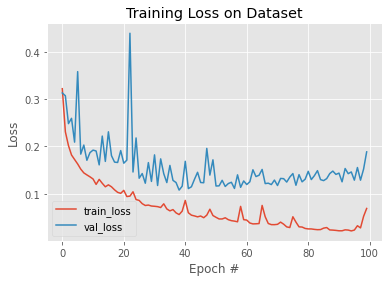

In [ ]:
# plot the training loss

print(MODEL_PATH)

PLOT_PATH = "/content/drive/MyDrive/plots/100-epochs"

plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(model, MODEL_PATH) # saves the model

As you can see the validation loss is jumping up and down. I do not know why this happens.

### Prediction part

Here the trained model is loaded and use for prediction on test images.

In [ ]:
# Get current working directory
cwd = os.getcwd()
print(cwd)

/content


In [ ]:
# Load saved model for prediction
model = torch.load("/content/drive/MyDrive/models/unet-100-epochs.pth")
print("model loaded for prediction")

model loaded for prediction


In [ ]:
# STOP Google Colab runtime
# !kill $(ps aux | awk '{print $2}')

Run prediction on test images that are stored in a folder, works with both PNG and TIF. If you work with TIF then just change the file ending in the paths.

In [ ]:
import random
import gc
from pathlib import Path
import numpy as np
from PIL import Image

# PLOTTING PREDICTIONS AS SINGLE IMAGES

# Output folder for the predictions
output_folder = '/content/drive/MyDrive/p100e/'

THRESHOLD = 0.5

# test_image_names
# test_image_names_subset --> ordered paths and names
#test_images --> arrays

# PLOT TEST IMAGES as RGB
for n in range(len(test_images)):
  gc.collect()
  # Test image number
  testImgName = str(Path(test_images[n]).stem) + '.png' # change for tif
  #print('#', testImgName)

   # Make predicton on a test image specified with counter n
  test_img = test_images[n]
  test_img_input = np.expand_dims(test_img, 0)
  #print('#', test_img_input[0])

  # PyTorch --> works
  model.eval()
  with torch.no_grad():
    image = cv2.imread(test_img_input[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255
    
    #print('SIZE: ', image.shape)

    # make the channel axis to be the leading one, add batch dimension
    image = np.transpose(image, (2, 0, 1))
    # create a PyTorch tensor
    image = np.expand_dims(image, 0)
    # flash the tensor to the device
    image  = torch.from_numpy(image).to(DEVICE)

    # make the prediction
    predMask = model(image).squeeze()
    # pass result through sigmoid
    predMask = torch.sigmoid(predMask)

    # convert result to numpy array
    predMask = predMask.cpu().numpy()

    # filter out the weak predictions and convert them to integers
    predMask = (predMask > THRESHOLD) * 255
    predMask = predMask.astype(np.uint8)

    # generate image from array
    pIMG = Image.fromarray(predMask)
    pIMG.save(str(output_folder + testImgName))

    print('Prediction:', testImgName, 'saved to:', output_folder)

Prediction: 6078_637_91.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6078_638_24.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6078_638_99.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6084_553_93.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6104_603_16.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6112_694_95.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6112_695_51.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6121_864_12.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6121_865_87.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6122_520_65.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6123_531_70.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6123_532_79.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6124_676_45.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6124_676_85.png saved to: /content/drive/MyDrive/p100e/
Prediction: 6124_677_55.png saved to: /content/d

### PREDICTION PART WITHOUT REGULARIZATION

Read the predictions from the folder where they were saved and compare the masks with the ground truth.

In [ ]:
import glob
predictions = glob.glob("/content/drive/MyDrive/p100e/*.png")
predictions.sort()
predictions

['/content/drive/MyDrive/p100e/6078_637_91.png',
 '/content/drive/MyDrive/p100e/6078_638_24.png',
 '/content/drive/MyDrive/p100e/6078_638_99.png',
 '/content/drive/MyDrive/p100e/6084_553_93.png',
 '/content/drive/MyDrive/p100e/6104_603_16.png',
 '/content/drive/MyDrive/p100e/6112_694_95.png',
 '/content/drive/MyDrive/p100e/6112_695_51.png',
 '/content/drive/MyDrive/p100e/6121_864_12.png',
 '/content/drive/MyDrive/p100e/6121_865_87.png',
 '/content/drive/MyDrive/p100e/6122_520_65.png',
 '/content/drive/MyDrive/p100e/6123_531_70.png',
 '/content/drive/MyDrive/p100e/6123_532_79.png',
 '/content/drive/MyDrive/p100e/6124_676_45.png',
 '/content/drive/MyDrive/p100e/6124_676_85.png',
 '/content/drive/MyDrive/p100e/6124_677_55.png',
 '/content/drive/MyDrive/p100e/6141_649_54.png',
 '/content/drive/MyDrive/p100e/6147_481_0.png',
 '/content/drive/MyDrive/p100e/6149_548_9.png',
 '/content/drive/MyDrive/p100e/6150_466_10.png',
 '/content/drive/MyDrive/p100e/6155_544_73.png',
 '/content/drive/MyDri

Code to plot the RGB, GT and the predicted image.

In [1]:
# WRITE A CODE TO SAVE RGB, GROUND TRUTH AND SEGMENTATION HERE
import matplotlib.pyplot as plt

n = 2 # change this number depending on which image you want to test

fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(131)

ax1.set_title('Testing image: ')
image = cv2.imread(test_images[n])[:,:,::-1]
ax1.imshow(image)
ax1.set_axis_off()

ax2 = fig.add_subplot(132)
ax2.set_title('Ground truth: ')
image = cv2.imread(test_masks[n])[:,:,::-1]
ax2.imshow(image)
ax2.set_axis_off()

ax3 = fig.add_subplot(133)
ax3.set_title('Prediction: ')
image = cv2.imread(predictions[n])[:,:,::-1]
ax3.imshow(image)
ax3.set_axis_off()

NameError: ignored

### BUILDING FOOTPRINT REGULARIZATION

Used repo: https://github.com/zorzi-s/projectRegularization

git clone the repo to the folder where your notebook is stored.

The Python files for projectRegularization need to be saved in Colab.

The pretrained weights need to be downloaded from the provided link:

https://drive.google.com/drive/folders/1IPrDpvFq9ODW7UtPAJR_T-gGzxDat_uu

In [2]:
# pretrained weights are saved in
ptw = "/content/drive/MyDrive/pretrained_weights/"

In [ ]:
# Go to variables.py --> and modify the file, provide the paths. See the example in this cell.
# if you modify only below, it will not work.

# CONFIGURE THE PATHS IN: variables.py NOT HERE!

# TRAINING
DATASET_RGB = "/tmp/mapai_small/train/images/*.png"
DATASET_GTI = "/tmp/mapai_small/train/masks/*.png"
DATASET_SEG = "/tmp/mapai_small/train/masks/*.png"

DEBUG_DIR = "/content/drive/MyDrive/debug/"

# INFERENCE
INF_RGB = "/tmp/mapai_small/test/images/*.png" # test RGB images
INF_SEG = "/content/drive/MyDrive/p100e/*.png" # test predictions
INF_OUT = "/content/drive/MyDrive/p100e_reg/" # folder to store regularizations

# PATHS TO THE GAN PRETRAINED WEIGHTS DOWNLOADED FROM GOOGLE DRIVE
MODEL_ENCODER = "/content/drive/MyDrive/pretrained_weights/E140000_e1"
MODEL_GENERATOR = "/content/drive/MyDrive/pretrained_weights/E140000_net"


In [ ]:
# Run the prediction issuing the command

# IF WORKING WITH TIF install imagecodecs
#!pip install imagecodecs  # only for TIF

# RUN REGULARIZATION
!python /content/drive/MyDrive/ColabNotebooks/regularize.py

/tmp/mapai_small/test/images/6078_637_91.png /content/drive/MyDrive/p100e/6078_637_91.png
Regularization: 100% 21/21 [00:08<00:00,  2.62it/s]
success...
/tmp/mapai_small/test/images/6078_638_24.png /content/drive/MyDrive/p100e/6078_638_24.png
Regularization: 100% 17/17 [00:00<00:00, 71.66it/s]
success...
/tmp/mapai_small/test/images/6078_638_99.png /content/drive/MyDrive/p100e/6078_638_99.png
Regularization: 100% 5/5 [00:00<00:00, 29.80it/s]
success...
/tmp/mapai_small/test/images/6084_553_93.png /content/drive/MyDrive/p100e/6084_553_93.png
Regularization: 0it [00:00, ?it/s]
/content/drive/MyDrive/ColabNotebooks/regularize.py:256: UserWarning: /content/drive/MyDrive/p100e_reg/6084_553_93.png is a low contrast image
  io.imsave(output_file, np.uint8(R*255))
success...
/tmp/mapai_small/test/images/6104_603_16.png /content/drive/MyDrive/p100e/6104_603_16.png
Regularization: 100% 16/16 [00:00<00:00, 72.04it/s]
success...
/tmp/mapai_small/test/images/6112_694_95.png /content/drive/MyDrive/p

In [ ]:
# Read Regularizations to plot and compare results

import glob
regularizations = glob.glob("/content/drive/MyDrive/p100e-regularized/*.png")
regularizations.sort()
regularizations

[]

In [ ]:
print(len(test_images))

### COMPARING THE FINAL RESULTS

Code to plot RGB, GT, PREDICTION and REGULARIZATION in a single plot for comparison.

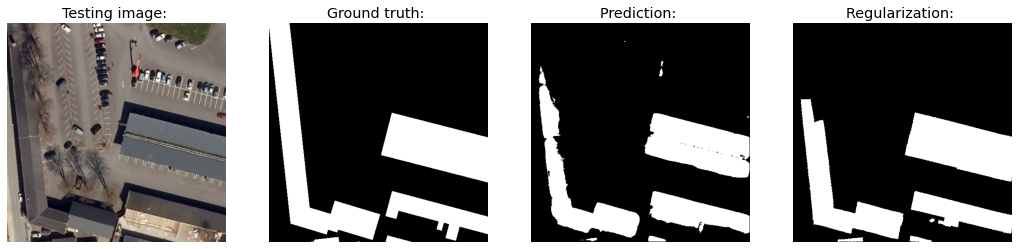

In [ ]:
### PLOT RGB, GT, PREDICTION and REGULARIZATION TOGETHER

# change plot to be used in a for loop

n = 1

fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(141)

ax1.set_title('Testing image: ')
image = cv2.imread(test_images[n])[:,:,::-1]
ax1.imshow(image)
ax1.set_axis_off()

ax2 = fig.add_subplot(142)
ax2.set_title('Ground truth: ')
image = cv2.imread(test_masks[n])[:,:,::-1]
ax2.imshow(image)
ax2.set_axis_off()

ax3 = fig.add_subplot(143)
ax3.set_title('Prediction: ')
image = cv2.imread(predictions[n])[:,:,::-1]
ax3.imshow(image)
ax3.set_axis_off()

ax4 = fig.add_subplot(144)
ax4.set_title('Regularization: ')
image = cv2.imread(regularizations[n])[:,:,::-1]
ax4.imshow(image)
ax4.set_axis_off()

fig.savefig("/content/drive/MyDrive/RESULTS_REGULARIZATION/compare1.png")

### VECTORIZING THE REGULARIZED BUILDING MASKS with GDAL

GDAL: https://gdal.org/'

GDAL: https://www.youtube.com/watch?v=q3DLdMj5zLA

I do not know if it is possible to install GDAL on WINDOWS inside a conda environment.

On Ubuntu you have to follow these steps:



Specific process for installation: https://stackoverflow.com/questions/44005694/no-module-named-gdal

- sudo apt-get update && sudo apt upgrade -y && sudo apt autoremove 
- sudo apt-get install -y cdo nco gdal-bin libgdal-dev-
- python -m pip install --upgrade pip setuptools wheel
- python -m pip install --upgrade gdal
- conda install -c conda forge libgdal
- conda install -c conda-forge libgdal
- conda install -c conda-forge gdal
- conda install tiledb=2.2
- conda install poppler

When you have this you can hopefully vectorize the detected masks quite easily.

In [ ]:
import osgeo
from osgeo import gdal
from osgeo import ogr
print('GDAL version: ', osgeo.gdal.__version__)

# in
input = "/content/drive/MyDrive/p100e_reg/6078_638_24.png"

# out
output = "/content/drive/MyDrive/p100e_reg/6078_638_24.shp" # vector file ready to be used in QGIS / ArcGIS Pro

# Open image with GDAl driver
ds = gdal.Open(input)
# Get the band
band = ds.GetRasterBand(1)

# Create the output shapefile
driver = ogr.GetDriverByName("ESRI Shapefile")
out_ds = driver.CreateDataSource(output)
out_layer = out_ds.CreateLayer(output, geom_type=ogr.wkbPolygon)

# Add a field to the layer to store the pixel values
field_defn = ogr.FieldDefn("Pix_Value", ogr.OFTInteger)
out_layer.CreateField(field_defn)

# Polygonize the PNG file
gdal.Polygonize(band, None, out_layer, 0, [], callback=None)

# Close the input and output files
out_ds = None
ds = None

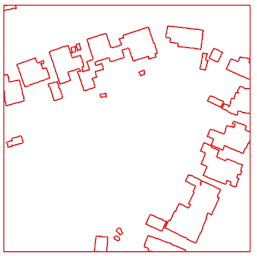

For the builing detection case we need to only keep the vectors with pixel value 255. Easiest solution is to use: Extract by attribute. The Python solution with GDAL can be found below.

In [ ]:
# ogr2ogr -where ID="1" outfile.shp infile.shp

# RUN from the command line inside Ubuntu
!ogr2ogr -where Pix_Value="255" 6078_638_24b.shp 6078_638_24.shp

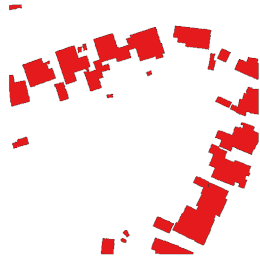

### GEOREFERENCING THE VECTORIZED MASKS

This is the last step for the practical applications of our methodology. I would need to obtain the geolocation files for the mapAI dataset, so I can georeference each mask from the test set.